# Práctico 2: Introducción al aprendizaje por refuerzos
## Integrantes:
    Analian
    Kraupl
    Piaggio
    
Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019


## Actividades

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools


import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition


In [3]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    #JPA Esto se llama cuando se hace model(s) que es lo mismo que hacer model.forward(s)
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [2]:
class DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
            
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [4]:
agent = DQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 11.0.
[Episode 100] - Mean reward 54.881188118811885.
[Episode 200] - Mean reward 60.527363184079604.
[Episode 300] - Mean reward 62.46843853820598.
[Episode 400] - Mean reward 64.25935162094763.
[Episode 500] - Mean reward 64.55489021956087.
[Episode 600] - Mean reward 67.15474209650583.
[Episode 700] - Mean reward 69.92724679029958.
[Episode 800] - Mean reward 73.3270911360799.
[Episode 900] - Mean reward 76.35627081021087.
[Episode 1000] - Mean reward 77.25674325674326.
[Episode 1100] - Mean reward 80.13260672116257.
[Episode 1200] - Mean reward 82.67360532889259.
[Episode 1300] - Mean reward 87.83013066871638.
[Episode 1400] - Mean reward 90.53961456102783.
[Episode 1500] - Mean reward 93.21518987341773.
[Episode 1600] - Mean reward 94.17489069331668.
[Episode 1700] - Mean reward 96.86478542034098.
[Episode 1800] - Mean reward 98.68850638534148.
[Episode 1900] - Mean reward 101.18253550762756.
[Episode 2000] - Mean reward 104.2823588205897.
[Episode 2100] 

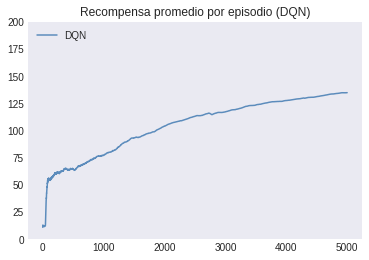

In [5]:
plt.plot(np.array(meanDQN), label='DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio (DQN)')
plt.legend(loc='upper left')
plt.show()

## 1. Double DQN

In [6]:
class DDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)        
            #next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            _, next_state_actions = self.model(non_final_next_states).max(1, keepdim=True)
            next_state_values[non_final_mask] = self.target(non_final_next_states).gather(1, next_state_actions).squeeze()                                
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
            
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [9]:
## Le bajo la cantidad de episodios porque demora mucho!
agent = DDQN(gym.make('CartPole-v0'), n_episodes=1000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 37.0.
[Episode 100] - Mean reward 81.57425742574257.
[Episode 200] - Mean reward 64.6268656716418.
[Episode 300] - Mean reward 54.840531561461795.
[Episode 400] - Mean reward 50.942643391521194.
[Episode 500] - Mean reward 49.6746506986028.
[Episode 600] - Mean reward 50.58569051580699.
[Episode 700] - Mean reward 49.31526390870185.
[Episode 800] - Mean reward 49.69538077403246.
[Episode 900] - Mean reward 49.3196448390677.
[Episode 999] - Mean reward 50.003.


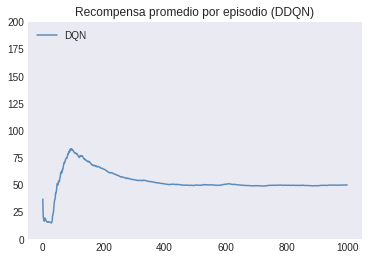

In [15]:
plt.plot(np.array(meanDDQN), label='DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio (DDQN)')
plt.legend(loc='upper left')
plt.show()

## Dueling DDQN

In [12]:
class DuelingNet(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(DuelingNet, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        #
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        
        adv = F.relu(self.advantage(x))
        x = self.output(x)
        return x + adv - adv.mean()

In [13]:
class DuelingDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = DuelingNet(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = DuelingNet(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [14]:
## Le bajo la cantidad de episodios porque demora mucho!
agent = DuelingDQN(gym.make('CartPole-v0'), n_episodes=1000, debug=True)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()

[Episode 0] - Mean reward 22.0.
[Episode 100] - Mean reward 88.23762376237623.
[Episode 200] - Mean reward 87.8905472636816.
[Episode 300] - Mean reward 75.0299003322259.
[Episode 400] - Mean reward 71.77057356608479.
[Episode 500] - Mean reward 73.14171656686626.
[Episode 600] - Mean reward 72.78036605657238.
[Episode 700] - Mean reward 72.54065620542083.
[Episode 800] - Mean reward 76.86766541822722.
[Episode 900] - Mean reward 82.3795782463929.
[Episode 999] - Mean reward 84.436.


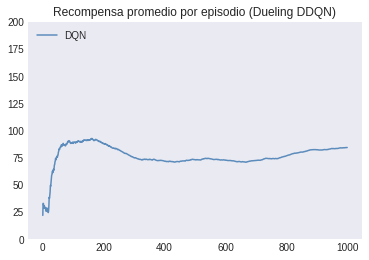

In [16]:
plt.plot(np.array(meanDuelingDDQN), label='DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio (Dueling DDQN)')
plt.legend(loc='upper left')
plt.show()

## 3. Cambiamos el entorno

In [18]:
##  probamos con 
agent = DDQN(gym.make('MountainCar-v0'), n_episodes=1000, debug=True)
newScoresDDQN, newMeanDDQN = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -200.0.
[Episode 500] - Mean reward -199.8443113772455.
[Episode 600] - Mean reward -198.86023294509152.
[Episode 700] - Mean reward -196.39372325249644.
[Episode 800] - Mean reward -196.5056179775281.
[Episode 900] - Mean reward -196.89345172031076.
[Episode 999] - Mean reward -197.101.


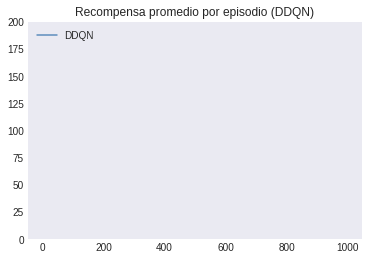

In [20]:
plt.plot(np.array(newScoresDDQN), label='DDQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio (DDQN)')
plt.legend(loc='upper left')
plt.show()